In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
import category_encoders as ce
import scipy.stats as stats
from scipy.stats import chi2_contingency, levene
import pingouin as pg
from collections import Counter



df_org = pd.read_csv(r"census_income_original_2.csv")
def create_family_status(row):
    if row['marital.status'] == 'Married-civ-spouse':
        return 'Married-with-family' if row['relationship'] in ['Husband', 'Wife'] else 'Married-alone'
        
    if row['marital.status'] == 'Never-married':
        return 'Single-with-family' if row['relationship'] in ['Own-child', 'Other-relative'] else 'Single-alone'
        
    if row['marital.status'] == 'Divorced':
        return 'Divorced-with-family' if row['relationship'] != 'Not-in-family' else 'Divorced-alone'
        
    if row['marital.status'] == 'Widowed':
        return 'Widowed-with-family' if row['relationship'] != 'Not-in-family' else 'Widowed-alone'
        
    if row['marital.status'] == 'Separated':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
    
    return 'Not-in-Family' 


C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_19164\4053913725.py:15: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv(r"census_income_original_2.csv")


In [2]:


# clean
df = df_org.copy()

# combine net gain and loss
df['capital.loss'] = df['capital.loss'] * -1
df['net_capital'] = df['capital.gain'] + df['capital.loss']
df['net_capital'] = df['net_capital'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

df.drop(columns=['capital.gain', 'capital.loss'], inplace=True)

# encode income
df['income>50k'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)


# handlin income_value missing values
df['income_value'] = pd.to_numeric(df['income_value'], errors='coerce')
df['income_value_encoded'] = np.where(
    (df['income>50k'] == 1) & (df['income_value'] > 50000), 1,
    np.where(
        (df['income>50k'] == 0) & (df['income_value'] <= 50000), -1,
        0 
    )
)
df.drop(columns=[ 'income', 'income_value'], inplace=True)
#df.drop(columns=[ 'ID', 'native.country', 'education','race'], inplace=True)


# handling missing catigorical variables
cat_cols = ['Gender', 'education.num', 'relationship', 'marital.status', 'occupation', 'net_capital', 'workclass', 'income>50k']
cont_cols = ['age', 'hours.per.week']
#cat_cols = ['relationship', 'occupation', 'education', 'marital.status', 'workclass']

for col in cat_cols:
    df[col] = df[col].replace('?', np.nan)
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)
df['family_status'] = df.apply(create_family_status, axis=1)

#encode gender
mapping = {
    'm': 0,'m ': 0,'M': 0,'malee': 0,'male ': 0,'male': 0,'Male': 0,'Female': 1,'female': 1,'f': 1
}
df['Gender'] = df['Gender'].map(mapping)

#df = pd.get_dummies(df, columns=cat_cols[:-1])


# rescale
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['age', 'hours.per.week']])
#df[['age', 'hours.per.week']] = df_scaled


quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42)
df[['age', 'hours.per.week']] = quantile_transformer.fit_transform(df[['age', 'hours.per.week']])
df.drop(columns=[ 'ID', 'education', 'race', 'native.country', 'workclass'], inplace=True)



In [3]:
df

,age,education.num,marital.status,occupation,relationship,Gender,hours.per.week,net_capital,income>50k,income_value_encoded,family_status
0,1.000000,9,Widowed,Exec-managerial,Not-in-family,1,0.474975,-1,0,-1,Widowed-alone
1,0.997248,9,Widowed,Exec-managerial,Not-in-family,1,0.050551,-1,0,-1,Widowed-alone
2,0.968468,10,Widowed,Exec-managerial,Unmarried,1,0.474975,-1,0,-1,Widowed-with-family
3,0.854855,4,Divorced,Machine-op-inspct,Unmarried,1,0.474975,-1,0,-1,Divorced-with-family
4,0.591091,10,Separated,"Prof-,specialty",Own-child,1,0.474975,-1,0,-1,Separated-with-family
...,...,...,...,...,...,...,...,...,...,...,...
33328,0.787788,10,Married-civ-spouse,Craft-repair,Husband,0,0.189189,-1,1,0,Married-with-family
33329,0.411411,10,Married-civ-spouse,Handlers-cleaners,Husband,0,0.474975,-1,1,0,Married-with-family
33330,0.903403,6,Married-civ-spouse,Transport-moving,Husband,0,0.474975,-1,1,0,Married-with-family
33331,0.880380,3,Married-civ-spouse,Exec-managerial,Husband,0,0.977227,-1,1,0,Married-with-family


C:\Users\t-aelmiggabbar\AppData\Local\anaconda3\envs\task3_env\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk Test for hours.per.week:
Statistic: 0.9003, p-value: 0.0000
The hours.per.week does not follow a normal distribution.

Shapiro-Wilk Test for age:
Statistic: 0.9558, p-value: 0.0000
The age does not follow a normal distribution.



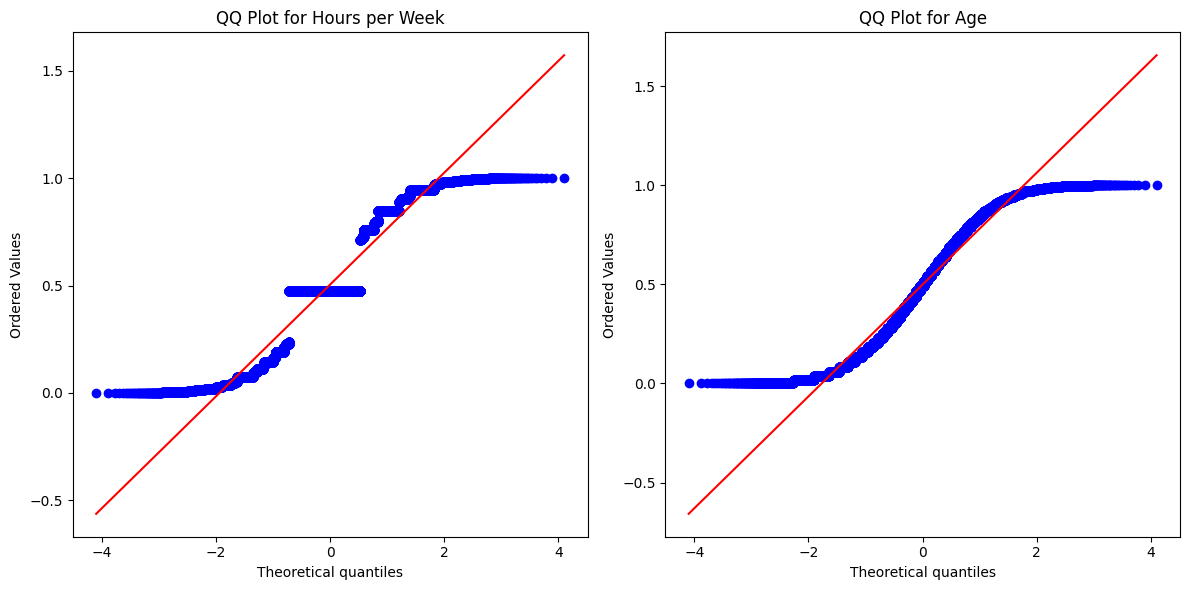

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame

# Shapiro-Wilk Test for Normality
def test_normality(data, column_name):
    stat, p_value = stats.shapiro(data[column_name])
    print(f"Shapiro-Wilk Test for {column_name}:")
    print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.05:
        print(f"The {column_name} follows a normal distribution.\n")
    else:
        print(f"The {column_name} does not follow a normal distribution.\n")

# Apply test for 'hours.per.week' and 'age'
test_normality(df, 'hours.per.week')
test_normality(df, 'age')

# QQ Plot for 'hours.per.week'
plt.figure(figsize=(12, 6))

# Plot for 'hours.per.week'
plt.subplot(1, 2, 1)
stats.probplot(df['hours.per.week'].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot for Hours per Week")

# Plot for 'age'
plt.subplot(1, 2, 2)
stats.probplot(df['age'].dropna(), dist="norm", plot=plt)
plt.title("QQ Plot for Age")

plt.tight_layout()
plt.show()


In [40]:
cont_cols = ['age', 'hours.per.week']
cat_cols = [col for col in df.columns if col not in cont_cols]

alpha = 0.05
test_results = []

for cont_var in cont_cols:
    for cat_var in cat_cols:
        groups = [group[cont_var].values for _, group in df.groupby(cat_var)]
        stat, p_val = levene(*groups, center='mean')
        
        if p_val > alpha:
            anova_results = pg.anova(dv=cont_var, between=cat_var, data=df)
            conclusion = "Used ANOVA."
        else:
            anova_results = pg.welch_anova(dv=cont_var, between=cat_var, data=df)
            conclusion = "Used Welch's ANOVA."
        
        p_value = anova_results['p-unc'][0]  
        effect_size = anova_results.loc[0, 'np2'] #efect size
        
        if p_value < alpha:
            significance = "Reject H0: significant difference."
        else:
            significance = "Fail to reject H0: No significant difference."
        
        test_results.append({
            'Continuous Variable': cont_var,
            'Categorical Variable': cat_var,
            'P-value': p_value,
            'Effect Size': effect_size,
            'Test Conclusion': conclusion,
            'Statistical Significance': significance
        })

# Convert results to DataFrame and save as CSV
results_df = pd.DataFrame(test_results)
results_df.to_csv('anova_welch_results.csv', index=False)


In [41]:
results_df.head(30)

,Continuous Variable,Categorical Variable,P-value,Effect Size,Test Conclusion,Statistical Significance
0,age,education.num,3.492056e-320,0.057525,Used Welch's ANOVA.,Reject H0: significant difference.
1,age,marital.status,1.342519e-288,0.356857,Used Welch's ANOVA.,Reject H0: significant difference.
2,age,occupation,2.597801e-136,0.039662,Used Welch's ANOVA.,Reject H0: significant difference.
3,age,relationship,0.000000e+00,0.266973,Used Welch's ANOVA.,Reject H0: significant difference.
4,age,Gender,5.226652e-75,0.010497,Used Welch's ANOVA.,Reject H0: significant difference.
5,age,net_capital,1.890601e-182,0.022798,Used Welch's ANOVA.,Reject H0: significant difference.
6,age,income>50k,0.000000e+00,0.076777,Used Welch's ANOVA.,Reject H0: significant difference.
7,age,income_value_encoded,3.774495e-23,0.013370,Used Welch's ANOVA.,Reject H0: significant difference.
8,age,family_status,0.000000e+00,0.398811,Used Welch's ANOVA.,Reject H0: significant difference.
9,hours.per.week,education.num,3.955523e-232,0.046648,Used Welch's ANOVA.,Reject H0: significant difference.


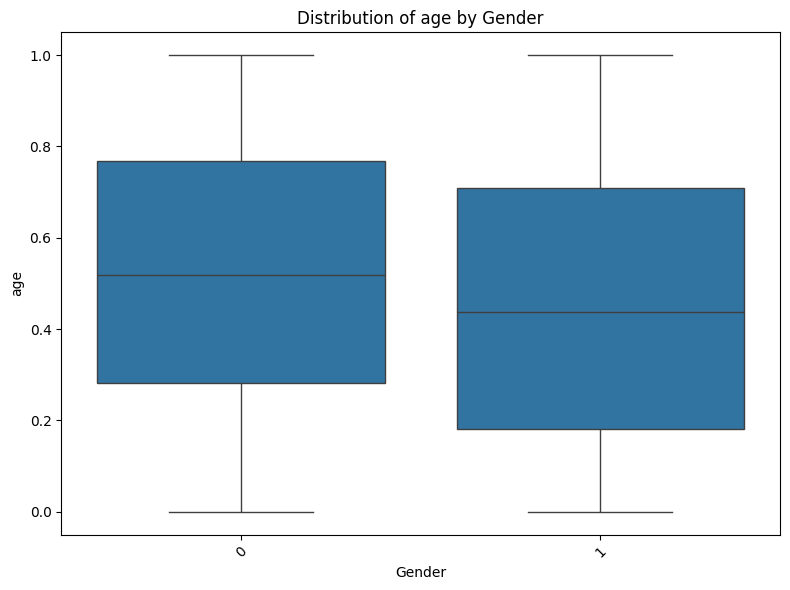

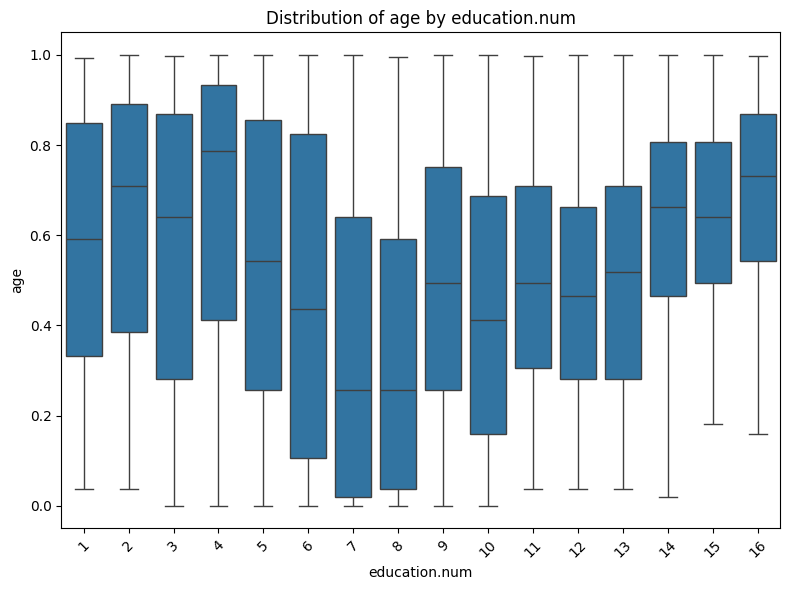

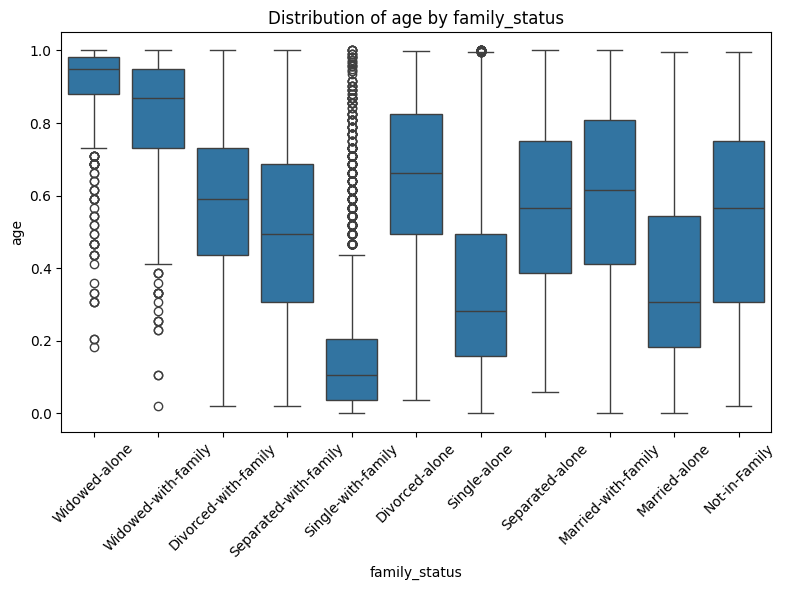

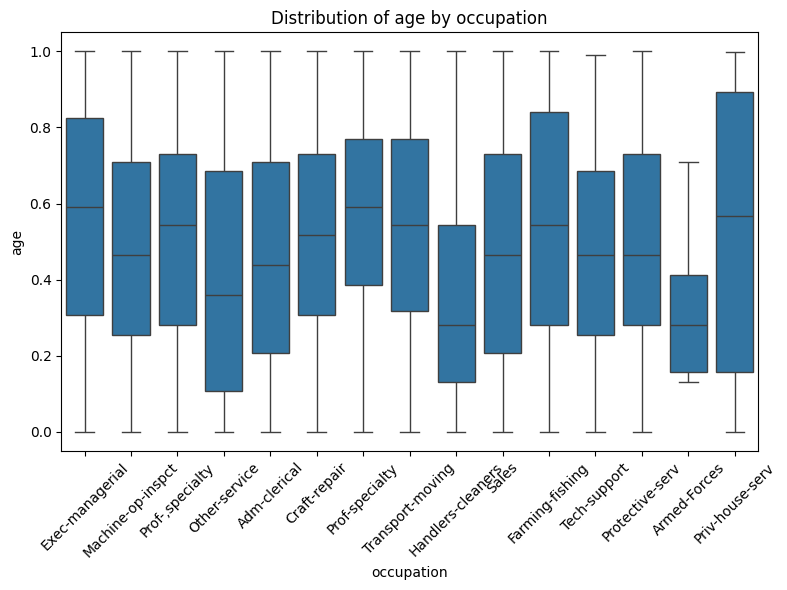

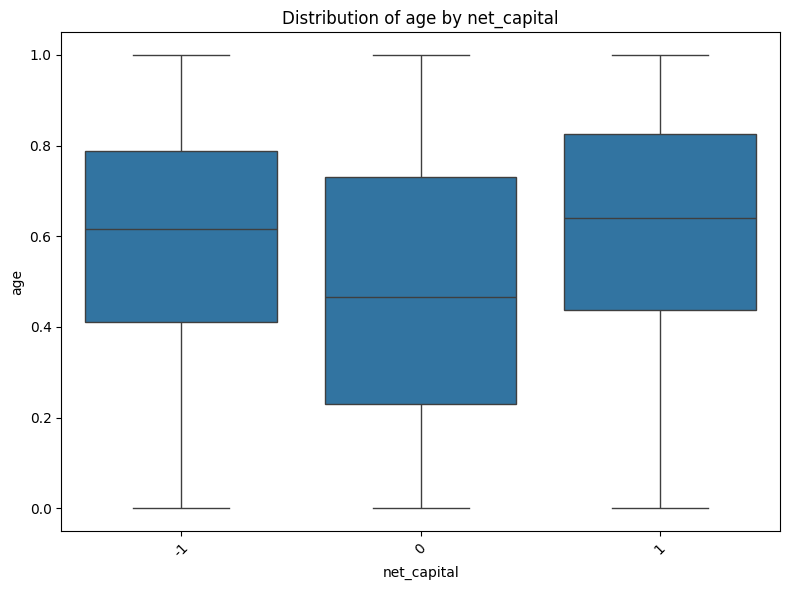

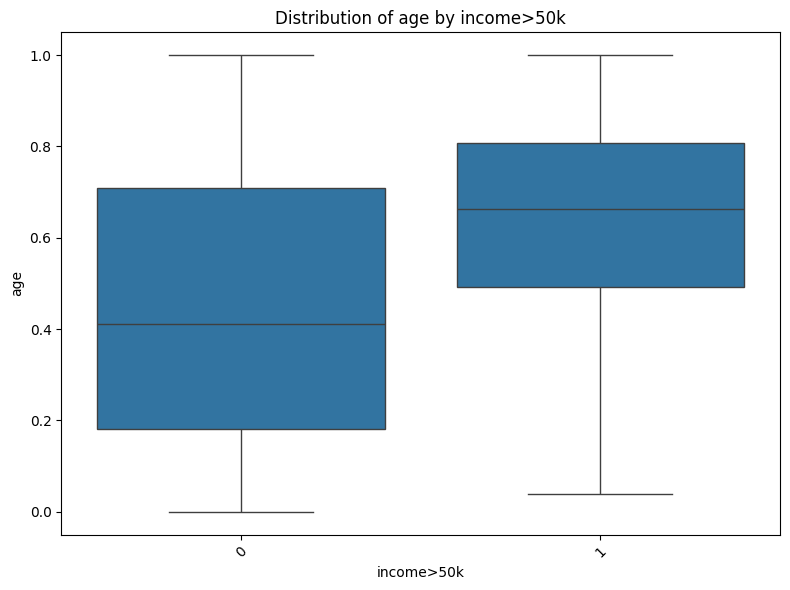

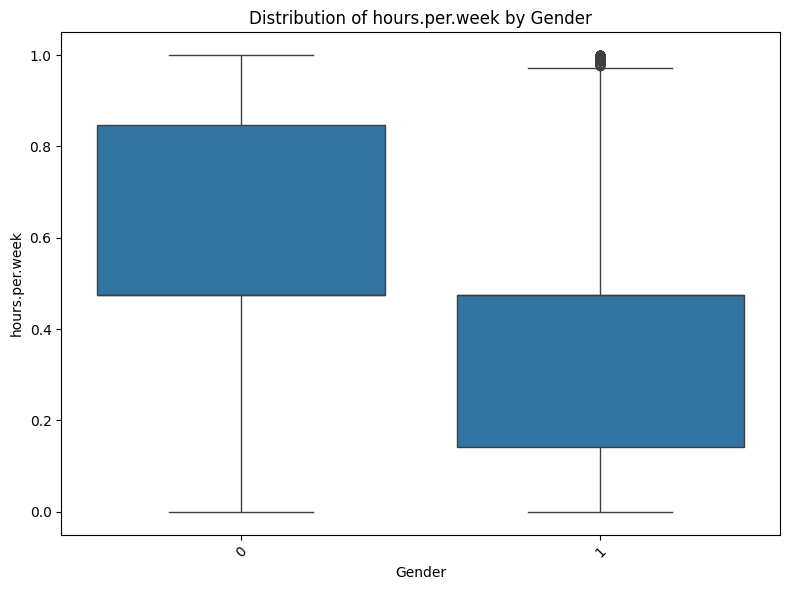

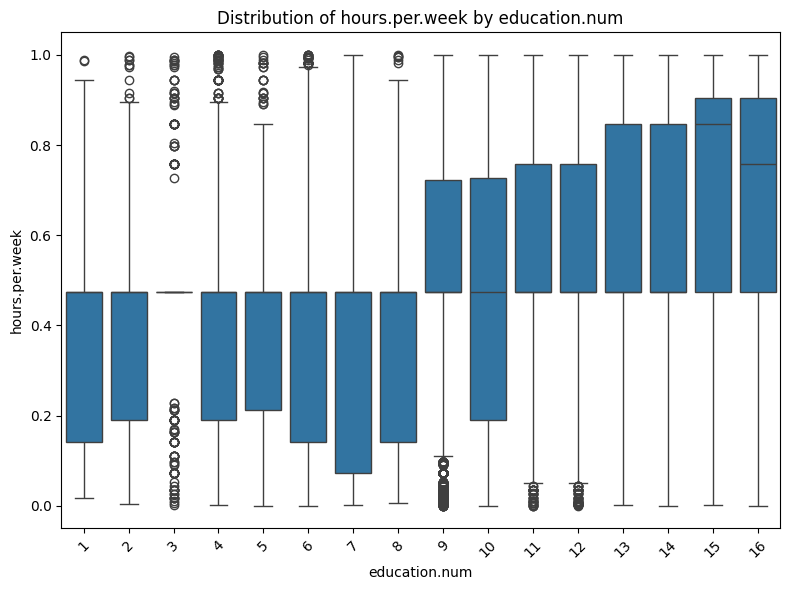

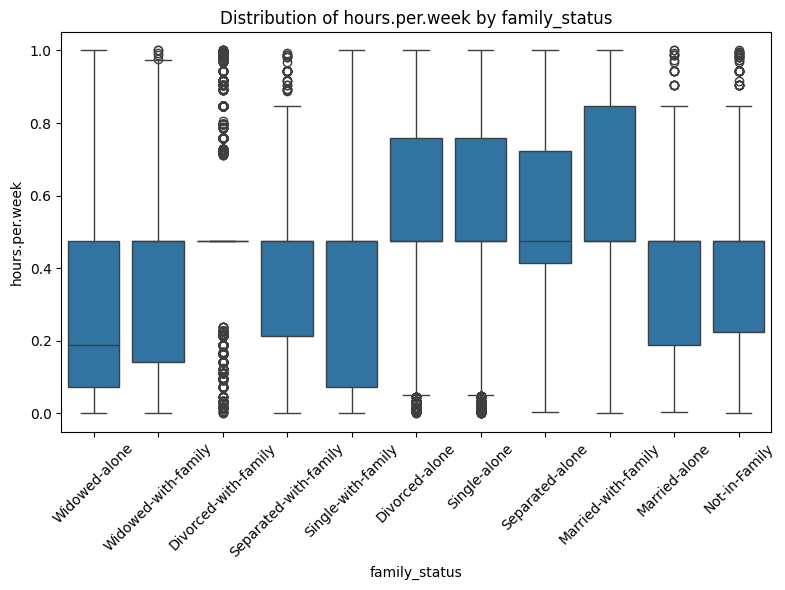

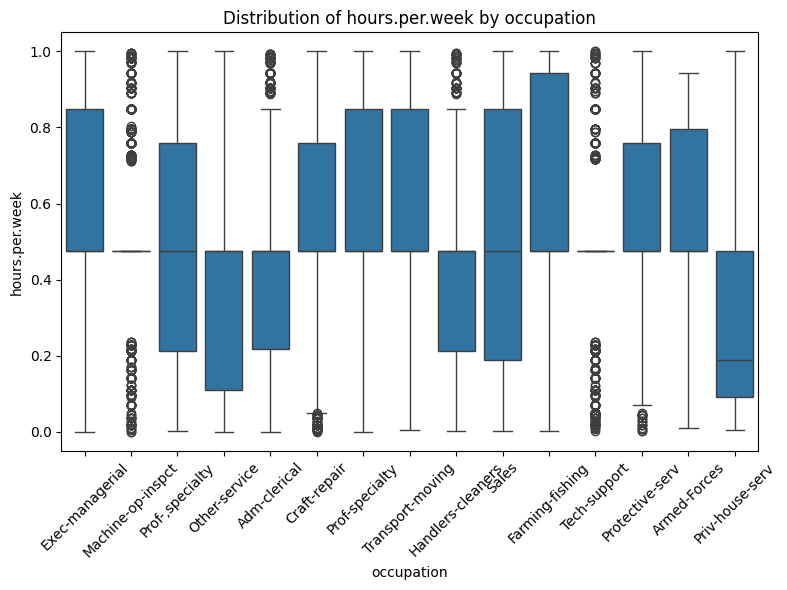

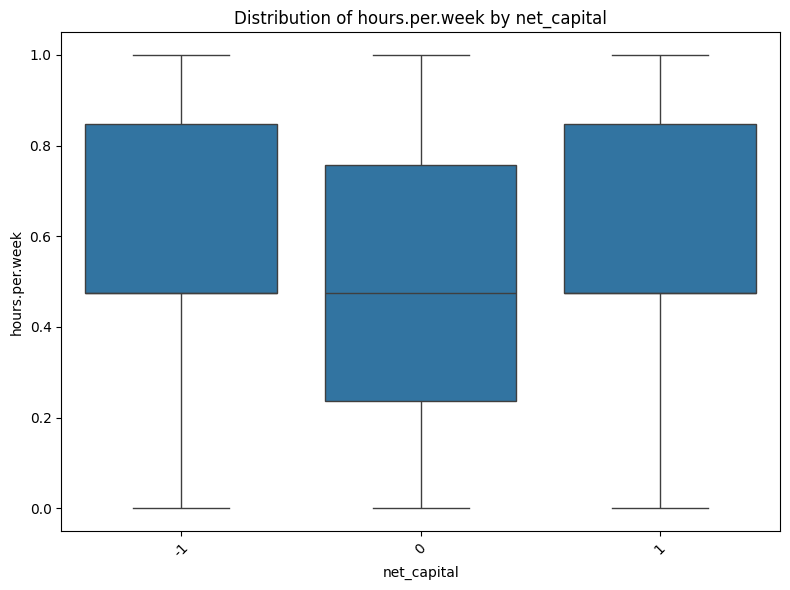

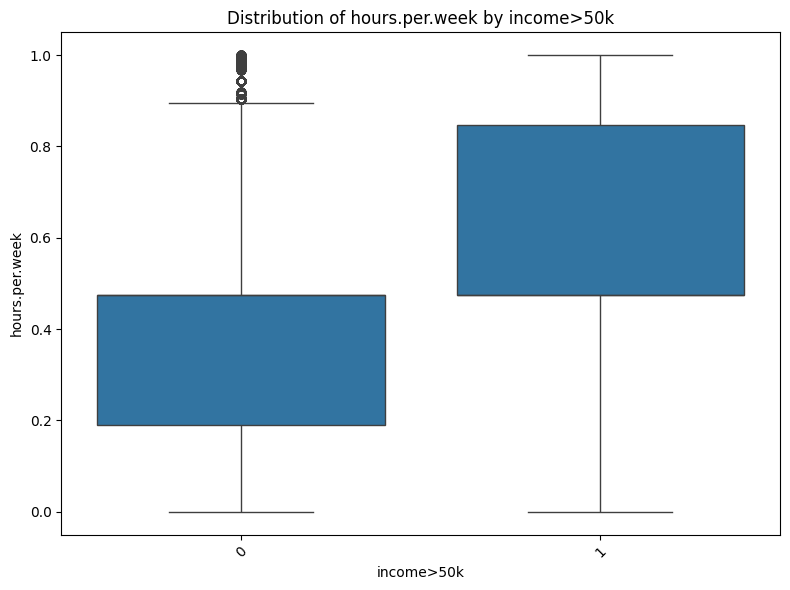

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
cat_cols = ['Gender', 'education.num', 'family_status', 'occupation', 'net_capital', 'income>50k']
for cont_var in cont_cols:
    for cat_var in cat_cols:
        plt.figure(figsize=(8, 6)) 
        sns.boxplot(x=cat_var, y=cont_var, data=df)
        plt.title(f"Distribution of {cont_var} by {cat_var}")
        plt.xticks(rotation=45)  
        plt.tight_layout()  
        plt.show()
